# Multi-Channel EGG Processing

`egg_process_multichannel` processes a `(n_channels, n_samples)` EGG
array using one of three named strategies:

| `method` | Description |
|---|---|
| `"per_channel"` | Run `egg_process` independently on every electrode; return per-channel metrics + best-channel index |
| `"best_channel"` | Select the electrode with the highest normogastric band power, then process that channel only |
| `"ica"` | Spatially denoise all channels with FastICA, then run `per_channel` on the reconstructed data |

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gastropy as gp

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Load the bundled 7-channel EGG dataset (Wolpert et al., 2020)
egg = gp.load_egg()
signal = egg["signal"]   # (7, n_samples)
sfreq = egg["sfreq"]
ch_names = list(egg["ch_names"])

print(f"{signal.shape[0]} channels, {signal.shape[1]} samples ({signal.shape[1]/sfreq:.0f} s @ {sfreq} Hz)")

7 channels, 7580 samples (758 s @ 10.0 Hz)


## Per-Channel Processing

Process each electrode independently. Returns a summary DataFrame with
peak frequency, instability coefficient, and proportion normogastric
for every channel, plus the index of the channel with the highest
normogastric band power.

In [2]:
result_per = gp.egg_process_multichannel(signal, sfreq, method="per_channel")

print("Per-channel summary:")
summary = result_per["summary"].copy()
summary.insert(1, "channel_name", ch_names)
print(summary.to_string(index=False, float_format="{:.4g}".format))
print(f"\nBest channel: {ch_names[result_per['best_idx']]} (index {result_per['best_idx']})")

Per-channel summary:
 channel channel_name  peak_freq_hz  instability_coefficient  proportion_normogastric  band_power_mean
       0         EGG1         0.052                   0.2115                   0.9211        2.388e-11
       1         EGG2         0.038                   0.3477                   0.8889        3.807e-10
       2         EGG3         0.052                   0.3595                   0.9143        6.718e-10
       3         EGG4         0.035                   0.1422                        1        8.955e-10
       4         EGG5         0.037                    1.408                    0.913        2.085e-10
       5         EGG6         0.053                   0.1759                   0.9459        8.264e-10
       6         EGG7         0.053                   0.7241                   0.9355        3.041e-10

Best channel: EGG4 (index 3)


## Best-Channel Processing

`method="best_channel"` selects the channel with the highest
normogastric band power and runs the full `egg_process` pipeline on it.
The returned dictionary has the same structure as a direct `egg_process`
call, with `info["best_channel_idx"]` added.

In [3]:
result_best = gp.egg_process_multichannel(signal, sfreq, method="best_channel")

best_idx = result_best["info"]["best_channel_idx"]
print(f"Best channel selected: {ch_names[best_idx]} (index {best_idx})")
print(f"Peak frequency       : {result_best['info']['peak_freq_hz']:.4f} Hz "
      f"({result_best['info']['peak_freq_hz'] * 60:.2f} cpm)")
print(f"Proportion normo     : {result_best['info']['proportion_normogastric']:.0%}")
print(f"Instability coeff.   : {result_best['info']['instability_coefficient']:.4f}")

Best channel selected: EGG6 (index 5)
Peak frequency       : 0.0530 Hz (3.18 cpm)
Proportion normo     : 95%
Instability coeff.   : 0.1759


## ICA Spatial Denoising

`method="ica"` applies FastICA across all channels to find statistically
independent components. Components whose gastric-band SNR falls below
`ica_snr_threshold` are zeroed out before reconstructing the signal.
The denoised data is then processed per-channel.

> **Note:** The default `ica_snr_threshold=3.0` is appropriate for typical
> recordings. Here we use a stricter threshold of **30.0** to demonstrate
> component removal on this clean dataset — two low-SNR components are
> discarded, visibly shifting the per-channel peak frequencies.

In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    result_ica = gp.egg_process_multichannel(
        signal, sfreq, method="ica",
        ica_snr_threshold=30.0,
        ica_random_state=42,
    )

ica_info = result_ica["ica_info"]
print(f"ICA components: {ica_info['n_components']} total, "
      f"{ica_info['n_kept']} kept, {ica_info['n_removed']} removed")
print(f"Component SNRs: {ica_info['component_snr'].round(2)}")

print("\nPer-channel summary after ICA denoising:")
ica_summary = result_ica["summary"].copy()
ica_summary.insert(1, "channel_name", ch_names)
print(ica_summary.to_string(index=False, float_format="{:.4g}".format))

ICA components: 7 total, 5 kept, 2 removed
Component SNRs: [ 30.39  44.94 132.53  52.32  28.79  54.93   2.33]

Per-channel summary after ICA denoising:
 channel channel_name  peak_freq_hz  instability_coefficient  proportion_normogastric  band_power_mean
       0         EGG1         0.053                  0.09653                   0.9737        2.758e-12
       1         EGG2         0.038                   0.2487                   0.8947        5.154e-10
       2         EGG3         0.037                   0.3323                   0.9143        7.914e-10
       3         EGG4         0.035                   0.1441                        1        8.978e-10
       4         EGG5         0.037                    1.389                   0.7222         1.24e-10
       5         EGG6         0.053                   0.1766                   0.9459        8.303e-10
       6         EGG7         0.053                   0.7563                      0.9        2.727e-10


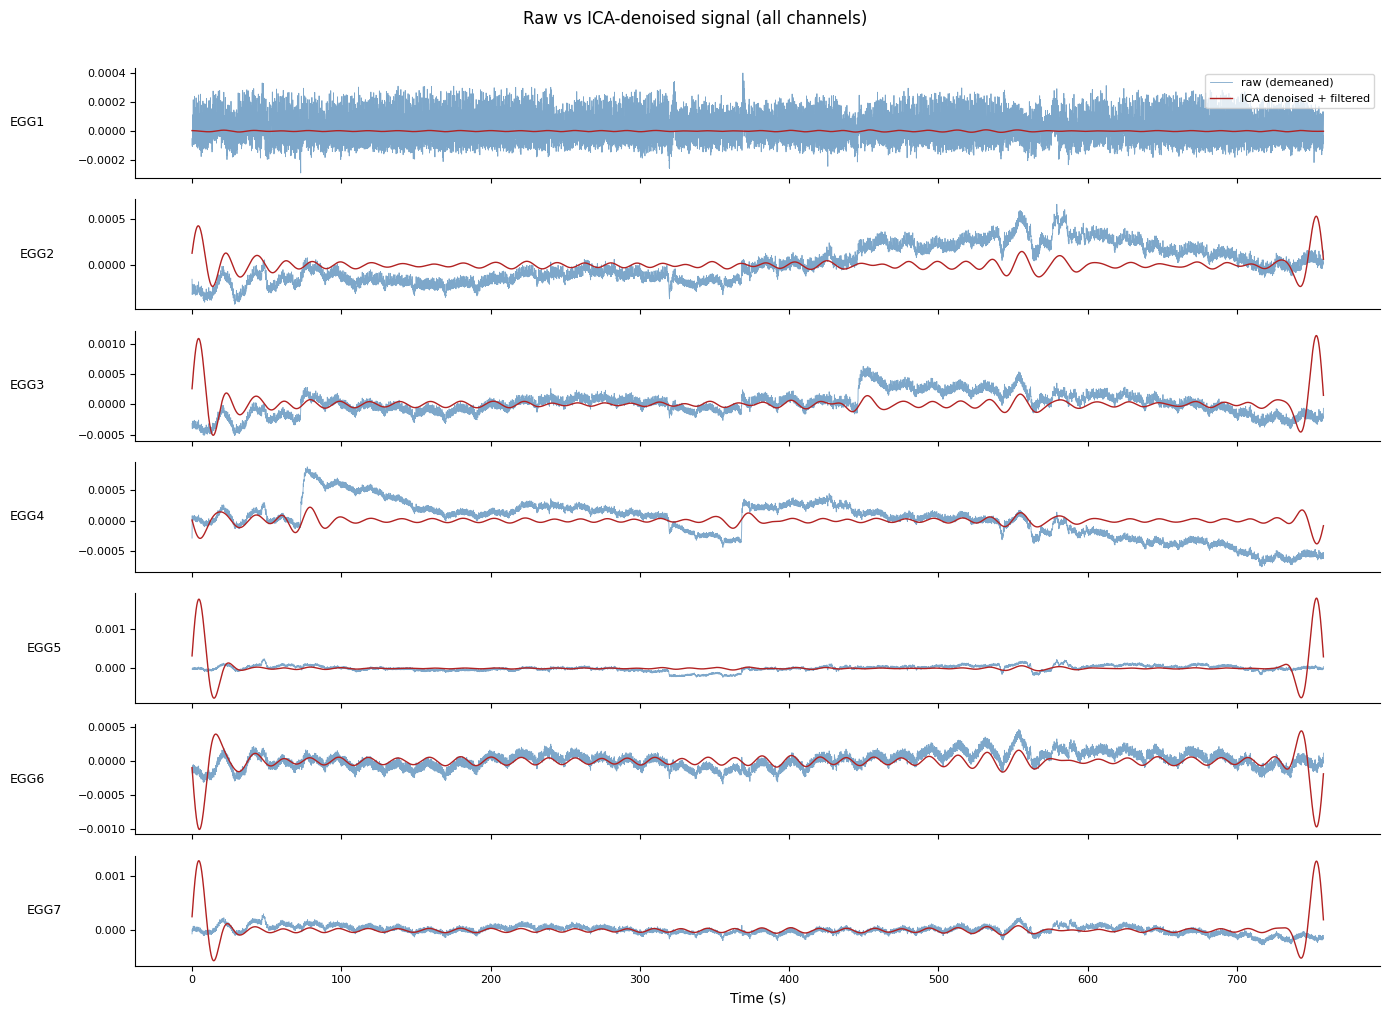

In [5]:
# Compare raw vs ICA-denoised timeseries for each channel
# Pull the denoised channel signals from the per-channel results
fig, axes = plt.subplots(len(ch_names), 1, figsize=(14, 10), sharex=True)
t = np.arange(signal.shape[1]) / sfreq

for i, (ax, name) in enumerate(zip(axes, ch_names)):
    raw_ch = signal[i] - signal[i].mean()
    ica_ch_signals = result_ica["channels"][i][0]
    ica_filtered = ica_ch_signals["filtered"].values
    ax.plot(t, raw_ch, lw=0.6, color="steelblue", alpha=0.7, label="raw (demeaned)")
    ax.plot(t, ica_filtered, lw=1.0, color="firebrick", label="ICA denoised + filtered")
    ax.set_ylabel(name, rotation=0, labelpad=36, va="center", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

axes[0].legend(loc="upper right", fontsize=8)
axes[-1].set_xlabel("Time (s)")
fig.suptitle("Raw vs ICA-denoised signal (all channels)", y=1.01)
fig.tight_layout()
plt.show()

## Compare Peak Frequencies Across Methods

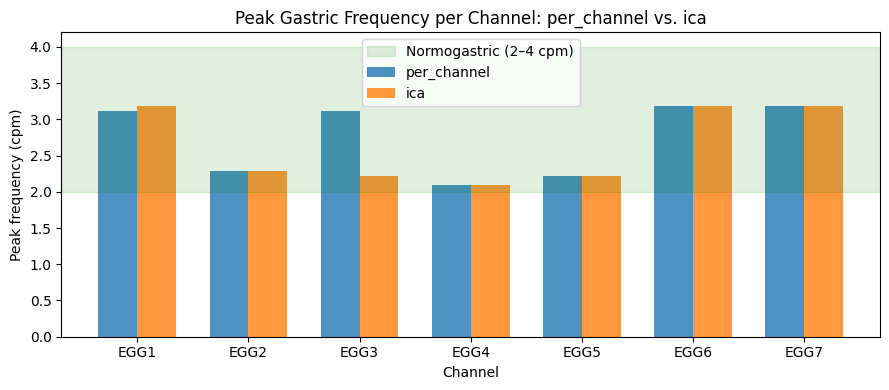

In [6]:
fig, ax = plt.subplots(figsize=(9, 4))

x = np.arange(len(ch_names))
w = 0.35

peak_per = result_per["summary"]["peak_freq_hz"].values * 60
peak_ica = result_ica["summary"]["peak_freq_hz"].values * 60

ax.bar(x - w/2, peak_per, width=w, label="per_channel", color="#1f77b4", alpha=0.8)
ax.bar(x + w/2, peak_ica, width=w, label="ica", color="#ff7f0e", alpha=0.8)
ax.axhspan(2, 4, alpha=0.12, color="green", label="Normogastric (2–4 cpm)")
ax.set_xticks(x)
ax.set_xticklabels(ch_names)
ax.set_xlabel("Channel")
ax.set_ylabel("Peak frequency (cpm)")
ax.set_title("Peak Gastric Frequency per Channel: per_channel vs. ica")
ax.legend()
plt.tight_layout()
plt.show()

**See also:**
[Channel Selection](channel_selection.ipynb),
[One-Call EGG Pipeline](egg_process.ipynb),
[Artifact Removal Strategies](artifact_removal.ipynb)